In [1]:
'''
@File    :   thend.ipynb
@Time    :   2023/07/23 14:57:22
@Author  :   Ravi K.
@Desc    :   A notebook for testing combination of everything we have done.
'''

'\n@File    :   thend.ipynb\n@Time    :   2023/07/23 14:57:22\n@Author  :   Ravi K.\n@Desc    :   A notebook for testing combination of everything we have done.\n'

In [2]:
import final_script as fs
import numpy as np
import processing_functions as pf
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import skewnorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.backends.backend_pdf
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'figure.dpi':150,
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [3]:
# snr, outliers, grb_mask, grb_snr = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB190928A/1s", 307372337.0, 2)[0]

In [4]:
# t, *_ = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/20-60/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1702)
# grb = np.zeros_like(t['RATE'])
# plt.figure(figsize=(10,7))
# plt.subplot(2,1,1)
# grb[outliers] = snr[0]
# plt.plot(t['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
# grb[outliers] = snr[1]
# plt.plot(t['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
# grb[outliers] = snr[2]
# plt.plot(t['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
# plt.title("GRB190928A")
# plt.xlabel("Outliers")
# plt.ylabel("SNR")
# plt.legend()
# plt.subplot(2,1,2)
# grb[outliers] = 0
# grb[outliers[grb_mask]] = grb_snr
# plt.plot(t['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [5]:
# snr, outliers, grb_mask, grb_snr = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB210709A/1s", 363502145.0, 2.5)[1]

In [6]:
# detrended, raw, trend, *_ = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins/20-60/AS1A10_073T02_9000004522_31247cztM0_level2_quad_clean_Q1.lc", 3513)
# grb = np.zeros_like(detrended['RATE'])
# plt.figure(figsize=(10,7), dpi=150)
# plt.subplot(2,1,1)
# grb[outliers] = snr[0]
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
# grb[outliers] = snr[1]
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
# grb[outliers] = snr[2]
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
# plt.title("GRB210709A")
# plt.xlabel("Outliers")
# plt.ylabel("SNR")
# plt.legend()
# plt.subplot(2,1,2)
# grb[outliers] = 0
# grb[outliers[grb_mask]] = grb_snr
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [7]:
data = fits.getdata("/home/ravioli/astro/ksp/grb/GRB160909A/master_lc/AS1G05_102T01_9000000650_05136cztM0_level2_quad_clean_Q0.lc")
trigger_times = np.concatenate((np.linspace(211079641.5+400, 211083090.5-100, 5), np.linspace(211084277.5+100, 211085869.5-100, 2)))
print(data['TIME'][0], data['TIME'][fs.get_saa_indices(data)[0]], data['TIME'][fs.get_saa_indices(data)[-1]], data['TIME'][-1])

211079641.5 211083090.5 211084277.5 211085869.5


In [10]:
# for trigger_time in trigger_times:
grb_name = "GRB210709A"
trigger_time = 363502145
results = fs.find_outliers("/home/ravioli/astro/ksp/grb/GRB210709A/1s", trigger_time, 1)
master_lcs = results[4]
lc_paths = np.sort(glob.glob(f"{results[5][0]}/*.lc"))

fs.find_possible_grbs(master_lcs, lc_paths, trigger_time, results, grb_name, plot=False)

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB210709A/1s/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins
Potential GRB found in Quadrant 0 at 363502147.5s with SNR 5.94!!!!
Potential GRB found in Quadrant 1 at 363502147.5s with SNR 6.95!!!!
Potential GRB found for trigger time 363502145s.


[5.936408519830007, 6.945573473423935]

In [9]:
detrended, raw, trend, filtered, *_ = fs.quadratic_detrend_trigger(master_lcs[1], trigger_index, polyorder=2)
detrended20to60, *_ = fs.quadratic_detrend_trigger(lc_paths[1], trigger_index, polyorder=2)
plt.figure(figsize=(13.18/1.5, 10/1.5), dpi=200)
plt.plot(raw['TIME'], raw['RATE'], color='slateblue', label='Raw Count Rate', alpha=0.85, linewidth=0.5)
plt.plot(raw['TIME'], trend, color='tomato', label='Trend', linewidth=1.5)
plt.plot(raw['TIME'], filtered, color='black', label='Savgol Filter', alpha=0.7, linewidth=1)
plt.fill_between(raw['TIME'], 0, raw['RATE'], color='slateblue', alpha=0.2)
plt.legend(loc='upper left', fontsize=12)
plt.xlim(raw['TIME'][0], raw['TIME'][-1])
plt.ylim(0, 200)
plt.xlabel("Time (s)", fontsize=14, labelpad=5)
plt.ylabel("Count Rate (counts/s)", fontsize=14, labelpad=5)
plt.title("GRB210730A - Quadrant 1", fontsize=16, pad=15)

NameError: name 'trigger_index' is not defined

Text(0.5, 1.0, 'GRB160909A - Quadrant 1')

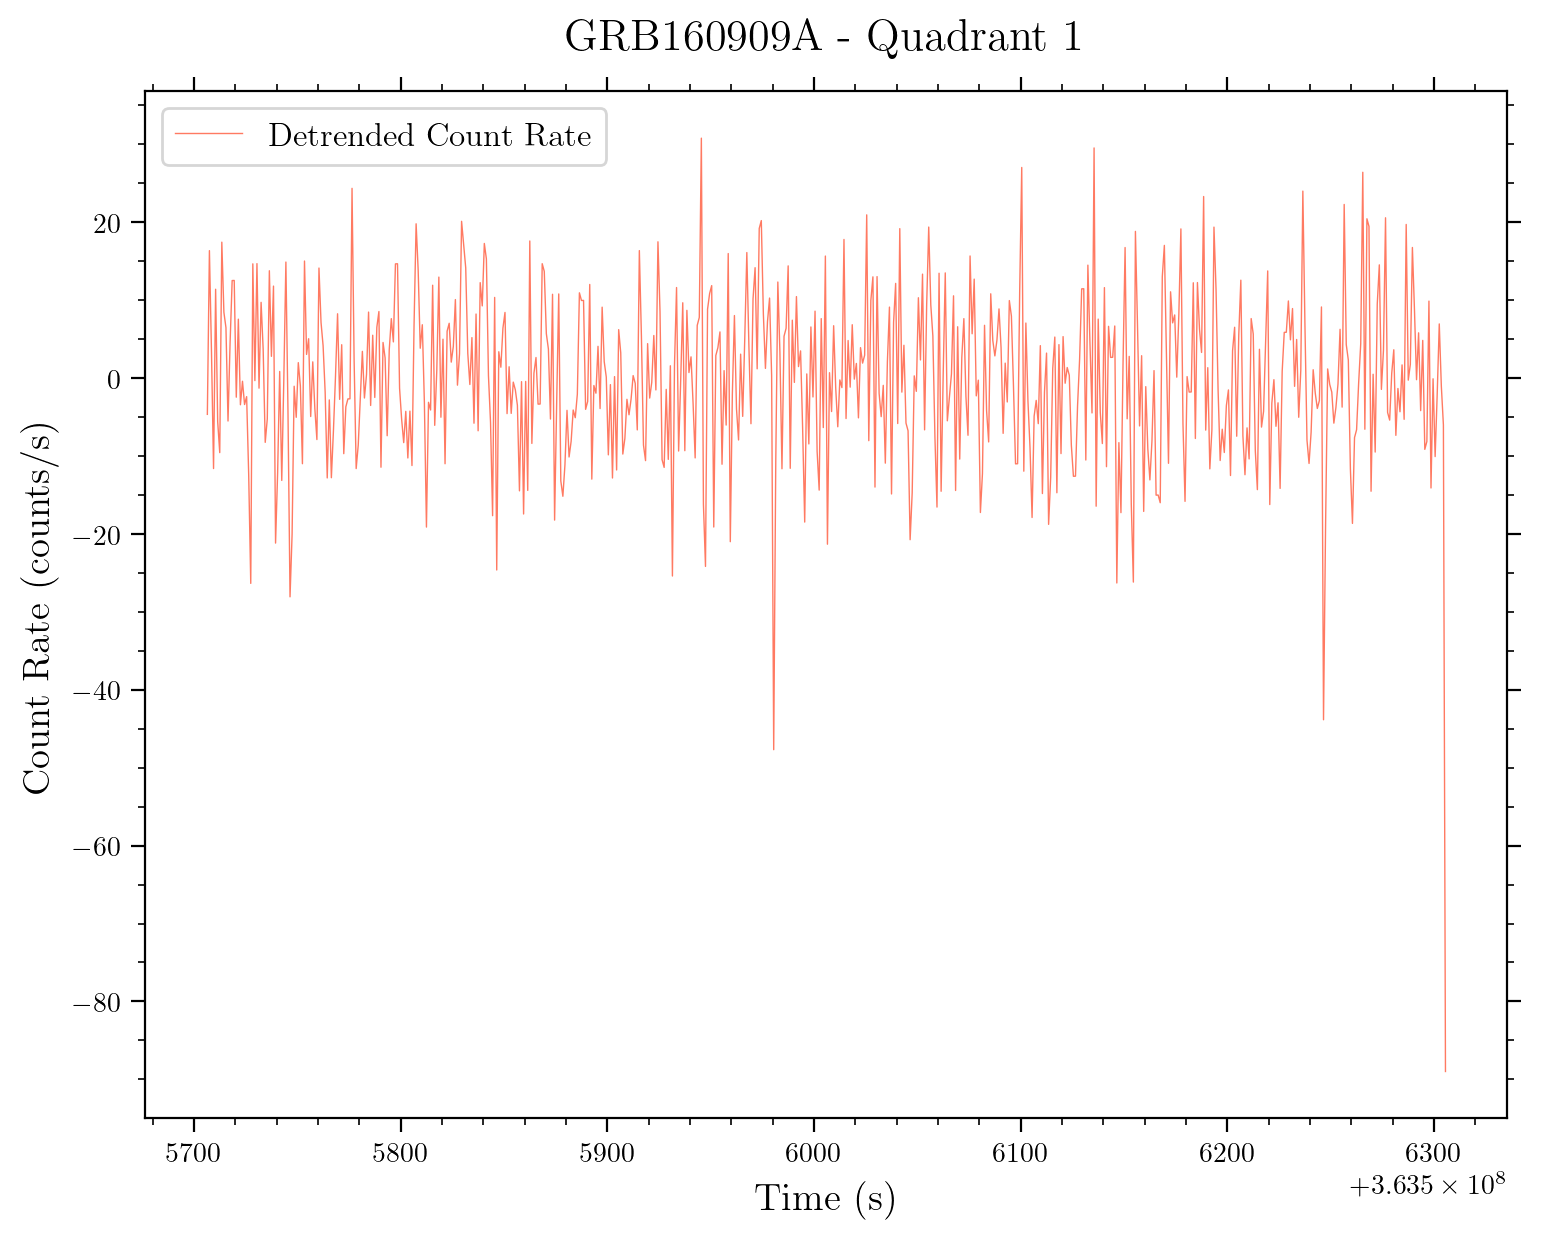

In [ ]:
plt.figure(figsize=(13.18/1.5, 10/1.5), dpi=200)
plt.plot(detrended['TIME'], detrended['RATE'], color='tomato', label='Detrended Count Rate', alpha=0.85, linewidth=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("Time (s)", fontsize=14, labelpad=5)
plt.ylabel("Count Rate (counts/s)", fontsize=14, labelpad=5)
plt.title("GRB160909A - Quadrant 1", fontsize=16, pad=15)

Text(0.5, 1.0, 'GRB210709A - Quadrant 1')

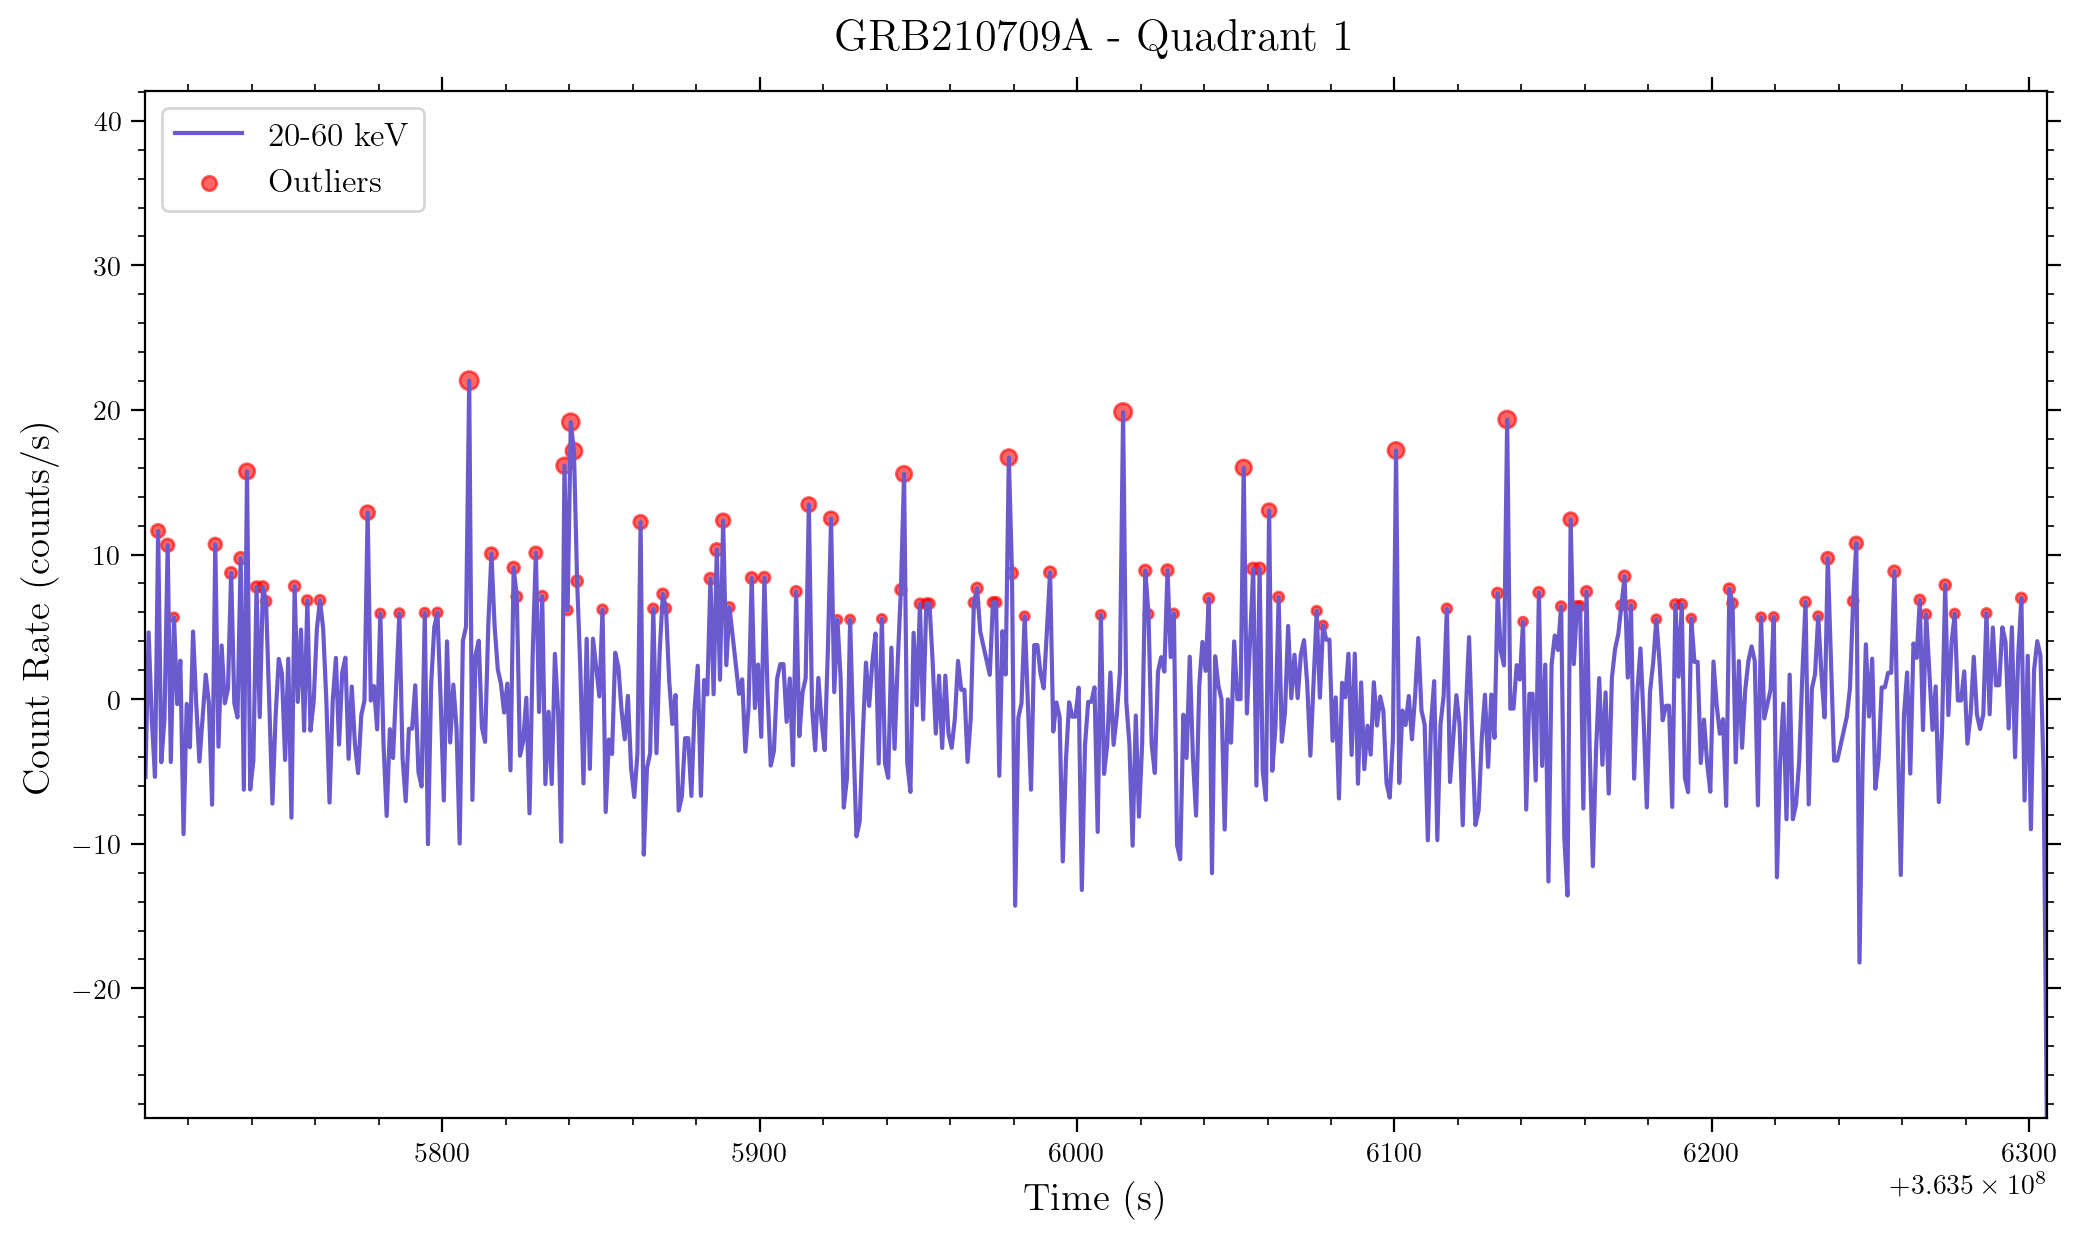

In [ ]:
snr, outliers, grb_mask, grb_snr = results[1]
plt.figure(figsize=(18.4/1.5, 10/1.5), dpi=200)
plt.plot(detrended20to60['TIME'], detrended20to60['RATE'], color='slateblue', label='20-60 keV')
plt.scatter(detrended20to60['TIME'][outliers], detrended20to60['RATE'][outliers], color='red', alpha=0.6, s=10*snr[0], label='Outliers')
plt.xlim(detrended20to60['TIME'][0], detrended20to60['TIME'][-1])
plt.ylim(min(detrended20to60['RATE']), max(detrended20to60['RATE'])+20)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("Time (s)", fontsize=14, labelpad=5)
plt.ylabel("Count Rate (counts/s)", fontsize=14, labelpad=5)
plt.title("GRB210709A - Quadrant 1", fontsize=16, pad=15)

In [ ]:
lc3bin1 = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/20-60/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1802)[0]
lc3bin2 = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/60-100/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1802)[0]
lc3bin3 = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/100-200/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1802)[0]
grb_time = (307372000, 307373000)

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB190928A/1s/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins


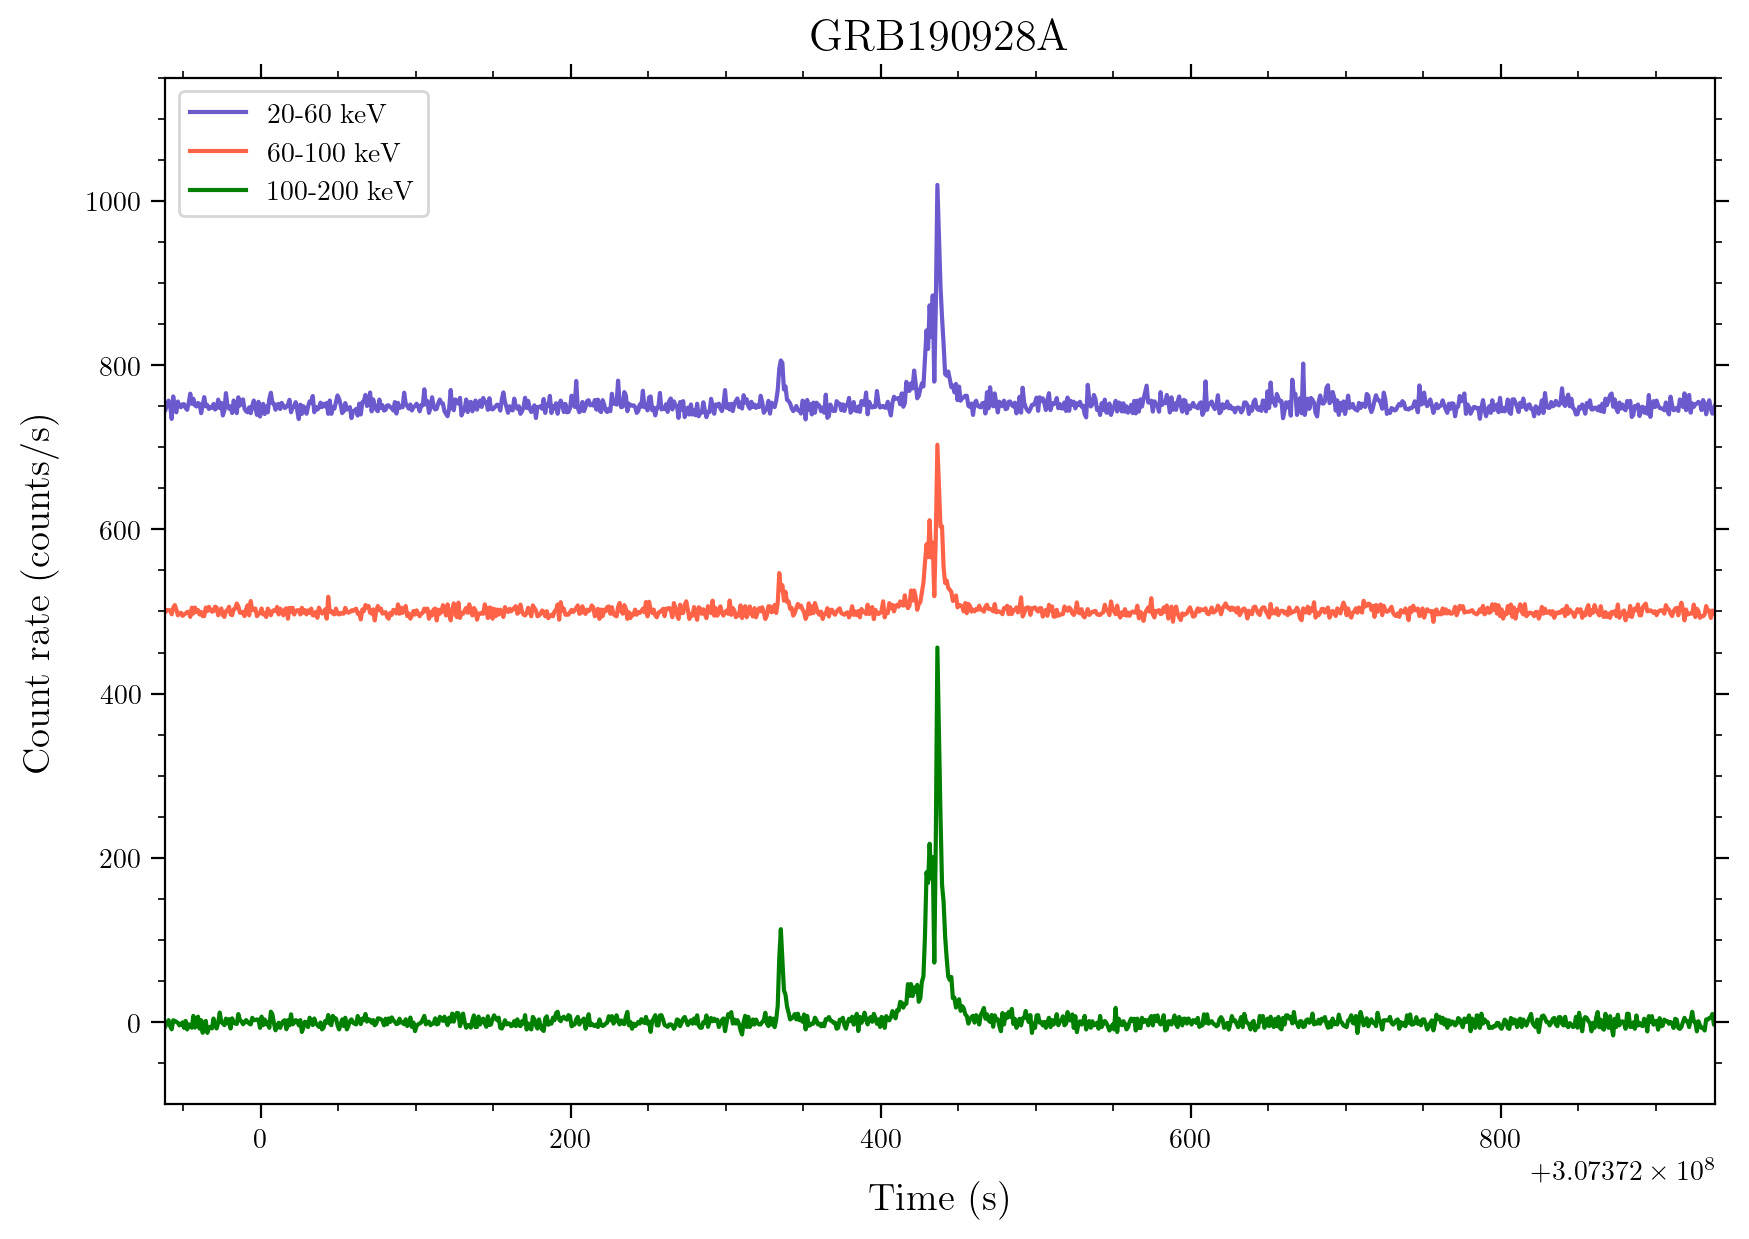

In [ ]:
results = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB190928A/1s", 307372437.0, 3)
outliers = results[0][1]
plt.figure(figsize=(15/1.5, 10/1.5), dpi=200)
plt.plot(lc3bin1['TIME'], lc3bin1['RATE']+750, color='slateblue', label='20-60 keV')
plt.plot(lc3bin2['TIME'], lc3bin2['RATE']+500, color='tomato', label='60-100 keV')
plt.plot(lc3bin3['TIME'], lc3bin3['RATE'], color='green', label='100-200 keV')
# plt.vlines(lc3bin1['TIME'][outliers], -100, 1200, linestyles='--', color='black', alpha=0.5, label="Outliers")
plt.xlim(lc3bin1['TIME'][0], lc3bin1['TIME'][-1])
plt.ylim(-100, 1150)
plt.xlabel("Time (s)", labelpad=10, fontsize=14)
plt.ylabel("Count rate (counts/s)", labelpad=10, fontsize=14)
plt.title("GRB190928A", pad=10, fontsize=16)
plt.legend(loc='upper left')